# Data filtration and quantum topological algorithm

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [1]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram

In this notebook we explain the persistent topological analysis, in particular how topological spectra can be obtained on different scales from a data filtration and how to extract Betti-numbers from them. For this the data cloud is described via a filtration of simplicial complexes, encoding topological and geometric features of the data on different filtration scales.

## Data filtration

Consider a finite set of data points in some metric space, and balls of radius $\varepsilon$ centered at each point. If another point is in the $\varepsilon$-ball of some point, draw a line (a 1-simplex) connecting both points, for any three points in one of the $\varepsilon$-balls draw a (filled) triangle (a 2-simplex) connecting all three points, and so on. The resulting combinatorial object is a collection of $k$-simplices of different orders $k$ and is called a **simplicial complex**.

<div>
<img src=pictures/PointCloud_small-eps.png" width="200"/>
</div>

The topology of the simplicial complex is determined by the number of holes in different dimensions: connected components (0-dimensional holes + 1), 1-dimensional holes, voids (2-dimensional holes), and so on. These numbers are called **Betti-numbers** $\beta_k$.

Constructing such a simplical complex of each radius $\varepsilon$ (respectively a finite set of radii), leads to a **filtration of simplicial complexes** describing the shape of the data points on different filtration scales $\varepsilon$.

<div>
<img src=pictures/PointCloud_big-eps.png" width="200"/>
</div>

A topological feature (e.g. the upper right 1-hole) that *persist* over a large range of $\varepsilon$ is often regarded as topological significant, while short-lived features typically are assumed to be topological noise. However, also such short-lived topological features can encode important information about the geometry of the data (reference!!!).

The *persistence* of the topological features on different topological orders can be summarized by means of a **persistence diagram**, where the birth and death of each feature plotted on the x-, respectively y-axis:

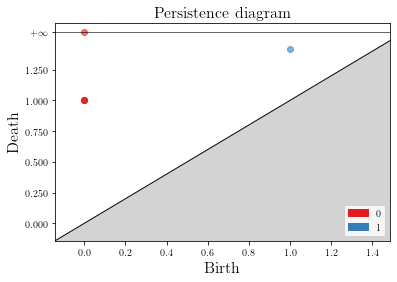

In [2]:
point_data = np.array([
    [0.,0.],
    [1.,0.],
    [1.,1.],
    [0.,1.],
    ])

# alternatively a distance matrix (here generated from the point data for exemplification)
# can be used
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(point_data, point_data)

filtration = qtda.data_filtration(
    data=point_data, 
#     distance_matrix=dist_mat, 
    max_dimension=3, 
    max_edge_length=2
    )

filtration.plot_persistence_diagram()

## Quantum algorithm for the topological analysis

The extraction of topological features builds on the famous quantum phase estimation (QPE) algorithm. As can be derived from Hodge theory, the $k$th Betti-number $\beta_k$ is equal to the dimension of the kernel (respectively of the 0-eigenspace) of the **combinatorial Laplacian** $\Delta_k$, which describes diffusion of information through the simplicial complex on the specific dimension ($\color{red}{\text{is this clear??}}$):
$$
\beta_k = \dim \ker \Delta_k = \dim \text{Eig}_0 \Delta_k \,.
$$

The compbinatorial Laplacian is a hermitian operator, hence its exponential $exp(i\Delta_k)$ is unitary and we can find its eigenvalue-decomposition by means of the QPE algorithm.

The QPE algorithm is provided by the `Qiskit` library and explained in detail in https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html. The circuit is illustrated below (picture from Qiskit Textbook)

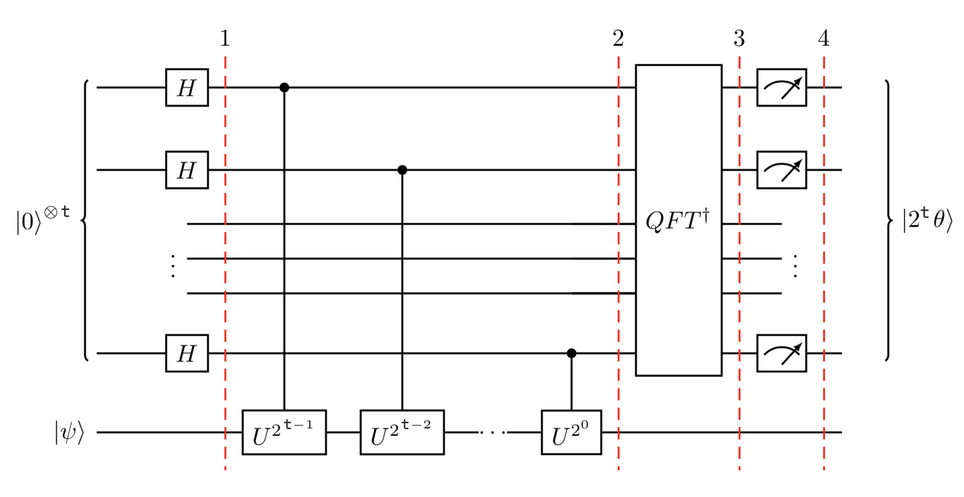

### Encoding simplices on qubits

We encode an arbitrary simplicial complex $S$, i.e. all its contained simplices on all orders, on $n$ vertices by means of $n$ qubits. This already provides an exponential memory advantage over classical algorithms, in which all simplices (the number of these grows exponentially with $n$) have to be stored on individual bit-strings.

Let $\lbrace s_k^i \rbrace_i$ be the set of $k$-simplices contained in the complex $S$. Each $s_k^i$ is encoded by a $n$-qubit state $\left| s_k^i \right\rangle = \left| 0,1,1,0,1,0,...,0 \right\rangle$ of $n$ qubits with exactly $k+1$ ones, describing the vertices that are included in the simplex. The projector $\rho_k$ onto all $k$-simplices in $S$ is given by
$$
\rho_k = \frac{1}{|\lbrace s_k^i \rbrace_i |} \sum_{s_k^i \in S} \left| s_k^i \right\rangle \left\langle s_k^i \right| \,,
$$
and is feeded as input state into the phase estimation algorithm.

The uniform superposition $\left| \psi_k \right\rangle= \sum_{s_k^i \in S} \left| s_k^i \right\rangle$ can be constructed by Grover's search algorithm by employing a classical oracle, deciding wheter a state $\left| 0,1,1,0,1,0,...,0 \right\rangle$ is included in the complex $S$. From this superposition $\rho_k$ can be easily obtained by employing a copy-register on which we copy the state-qubits, which afterwards is traced out. In our work, because of the limited time horizon, the input state $\left| \psi_k \right\rangle$ is directly initialized using the Qiskit library.

### Example circuit

As an example, the quantum circuit for the topological analysis of an example simplicial complex of four abstract points is draw. The complex is shown below. To detect to 1-dimensional hole in the simplex $[1,1,1,0]$, we have to find the dimension of the 0-Eigenspace of the combinatorial Laplacian $\Delta_k$ on first order $k=1$.

<div>
<img src=pictures/sample_simpl_complex.png" width="300"/>
</div>

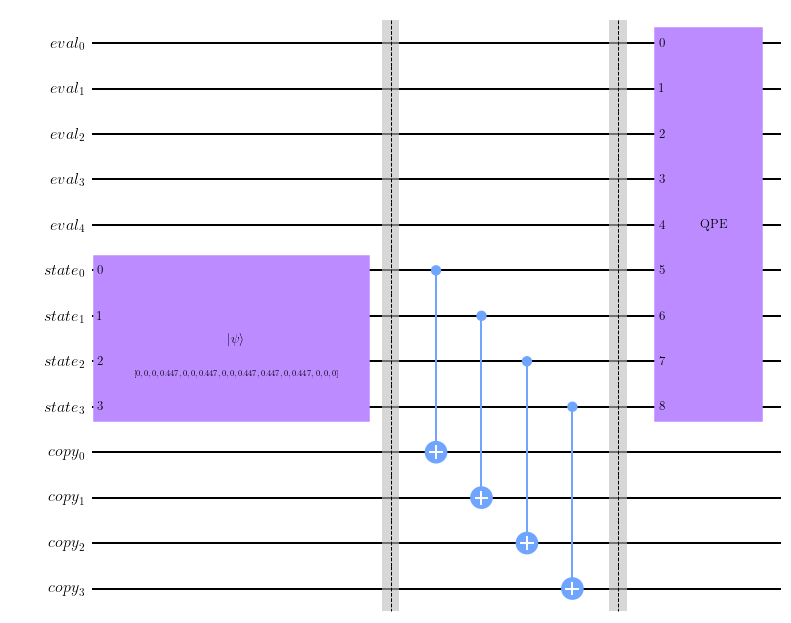

In [11]:
n_vertices = 4 # number of qubits to represent the simplicial complex
num_eval_qubits = 5 # number of numerical evaluation qubits for the QPE algorithm

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = [(1,0,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDA_algorithm(num_eval_qubits, k, state_dict)
qc.draw('mpl')

Empoying $\rho_k$ as input state for the QPE algorithm, we see that the dimension of the eigenspace to eigenvalue $\omega$ is proportional to the probability of measuring the phase $\varphi = \frac{\omega}{2\pi}$ at the output of the phase estimation protocol:

$$
\dim \text{Eig}_\omega \Delta_k = | \lbrace s_k^i \rbrace_i | \; \text{Prob} \left( \frac{\omega}{2\pi} \right)
$$

In our example, the first Betti-number $\beta_1$, i.e. the number of 1-holes, is hence given by 

$$
\beta_1 = \dim \text{Eig}_0 \Delta_1 = 5 \; \text{Prob} \left( \frac{0}{2\pi} \right)
$$

We estimate $\beta_1$ from the output counting statics, by adding measurements on the evaluation qubits (listed in `qc.eval_qubits`).

In [12]:
from qiskit import ClassicalRegister, Aer, execute
# from qiskit import IBMQ, Aer, transpile, assemble

qc.add_register(ClassicalRegister(num_eval_qubits))
for q in qc.eval_qubits:
    qc.measure(q,q)

shots = 1000
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=shots)
counts = job.result().get_counts(qc)

The number of 1-holes is 0.94


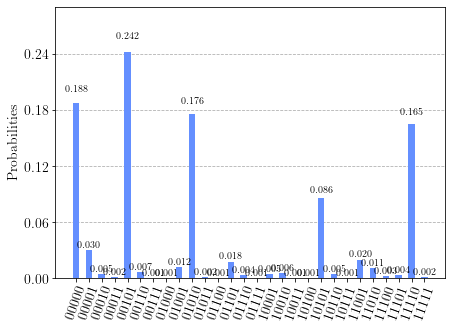

In [13]:
dim = len(state_dict[1]) # dimension of 1-simplex space
prob = counts.get("0"*num_eval_qubits)/shots # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

..., i.e. approximately $\beta_1 = 1$, in line of what we would expect from the picture of the simplicial complex.

## Topological spectra

The algorithm actually allows us to extract further geometric information from the simplical complex, which is encoded in all the eigenvalues of $\Delta_k$ on all orders $k=1,2,3$. To obtain the full topological spectra with the dimensions of the corresponding eigenspaces, we call `qtda.Q_top_spectra` and extract the topological spectra. Note that to obtain reliable estimates for all eigenvalues, a larger numerical precision (`num_eval_qubits`) of the phase estimation algorithm is necessary.

In [14]:
shots = 500
num_eval_qubits = 10

data = qtda.Q_top_spectra(state_dict, num_eval_qubits, shots)
spectra = data.get_spectra()

Topological order:  0
Topological order:  1
Topological order:  2
Topological order:  3
calculation terminated because no simplex of dimension 3



Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 0.976, 1.209958460913371: 2.872}


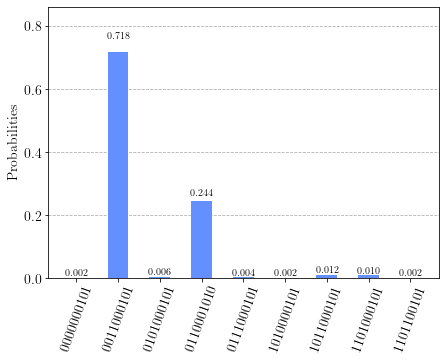


Topological order:  1
Number of holes:  0.91
Dimension of the k-simplex subspace:  5
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0.91, 3.722004199560928: 1.06, 1.209958460913371: 2.05, 2.419916921826742: 0.86}


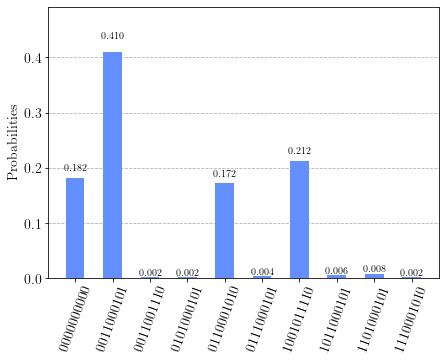


Topological order:  2
Number of holes:  0
Dimension of the k-simplex subspace:  1
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 3.722004199560928: 0.988}


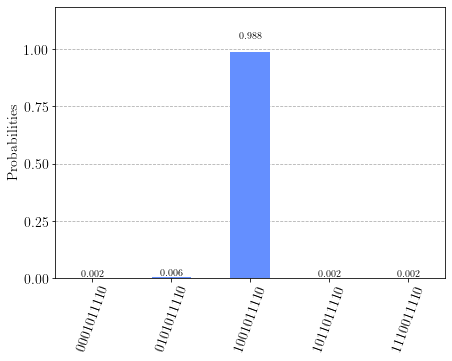

In [15]:
for top_order in spectra.keys():
    print()
    print('Topological order: ', top_order)
    print('Number of holes: ', spectra[top_order][0.0])
    print('Dimension of the k-simplex subspace: ', len(data.state_dict[top_order]))
    print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
    print(spectra[top_order])
    display(plot_histogram(data.get_counts()[top_order]))

Only eigenvalues are considered with at least 2% probability, all others are considered as noise. The chop-value (minimum number of counts) can be set in the `get_spectra(chop=..)` method. We see that the dimensions of the eigenspaces sum up approximately to the dimension of the k-simplex space, as expected.

This can be compared to the simplicial complex, where both triangles are filled with a 2-simplex. For this we have to consider 2-simplices $S2 = [(1,0,1,1), (1,1,1,0)]$, instead.

In [7]:
n_vertices = 4

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = [(1,0,1,1), (1,1,1,0)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

shots = 500
num_eval_qubits = 10

data = qtda.Q_top_spectra(state_dict, num_eval_qubits, shots)
spectra = data.get_spectra()

Topological order:  0
Topological order:  1
Topological order:  2
Topological order:  3
calculation terminated because no simplex of dimension 3



Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 1.088, 1.209958460913371: 2.84}


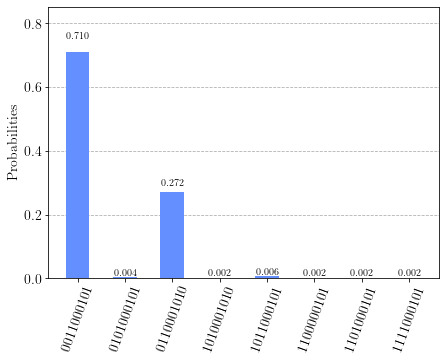


Topological order:  1
Number of holes:  0
Dimension of the k-simplex subspace:  5
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 2.15, 1.209958460913371: 2.73}


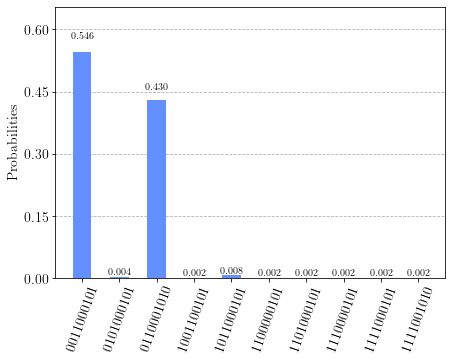


Topological order:  2
Number of holes:  0
Dimension of the k-simplex subspace:  2
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 1.028, 1.209958460913371: 0.928}


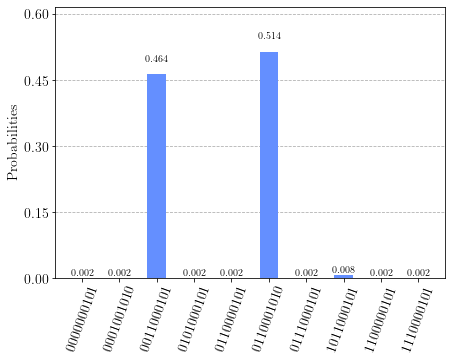

In [8]:
for top_order in spectra.keys():
    print()
    print('Topological order: ', top_order)
    print('Number of holes: ', spectra[top_order][0.0])
    print('Dimension of the k-simplex subspace: ', len(data.state_dict[top_order]))
    print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
    print(spectra[top_order])
    display(plot_histogram(data.get_counts()[top_order]))